In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import math
from scipy.optimize import curve_fit

In [53]:
# Define the hazard function calculator
def hazard_function_empirical_time(df):
    generation_times = np.asarray(df["generationtime"], dtype=float)
    generation_times = generation_times[np.isfinite(generation_times)]
    generation_times = np.sort(generation_times)
    min_diff = 0.001
    for i in range(len(generation_times) - 1):
        diff = generation_times[i + 1] - generation_times[i]
        if diff < min_diff and diff > 0:
            min_diff = diff
    N_t = len(generation_times)
    t_max = np.max(generation_times)
    grid = np.arange(0, t_max + min_diff, min_diff)
    survival = [(generation_times > t).sum()/N_t for t in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for t in range(len(grid) - 1):
        hazard[t] = (-1/survival[t]) * (survival[t+1] - survival[t])/(grid[t+1] - grid[t])
    return grid, hazard/sum(hazard), survival[:-1]

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.01
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

In [54]:
#Make a dictionary of dataframes
dfs = {}                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    dfs[name] = pd.read_csv(path)

dfs
# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass

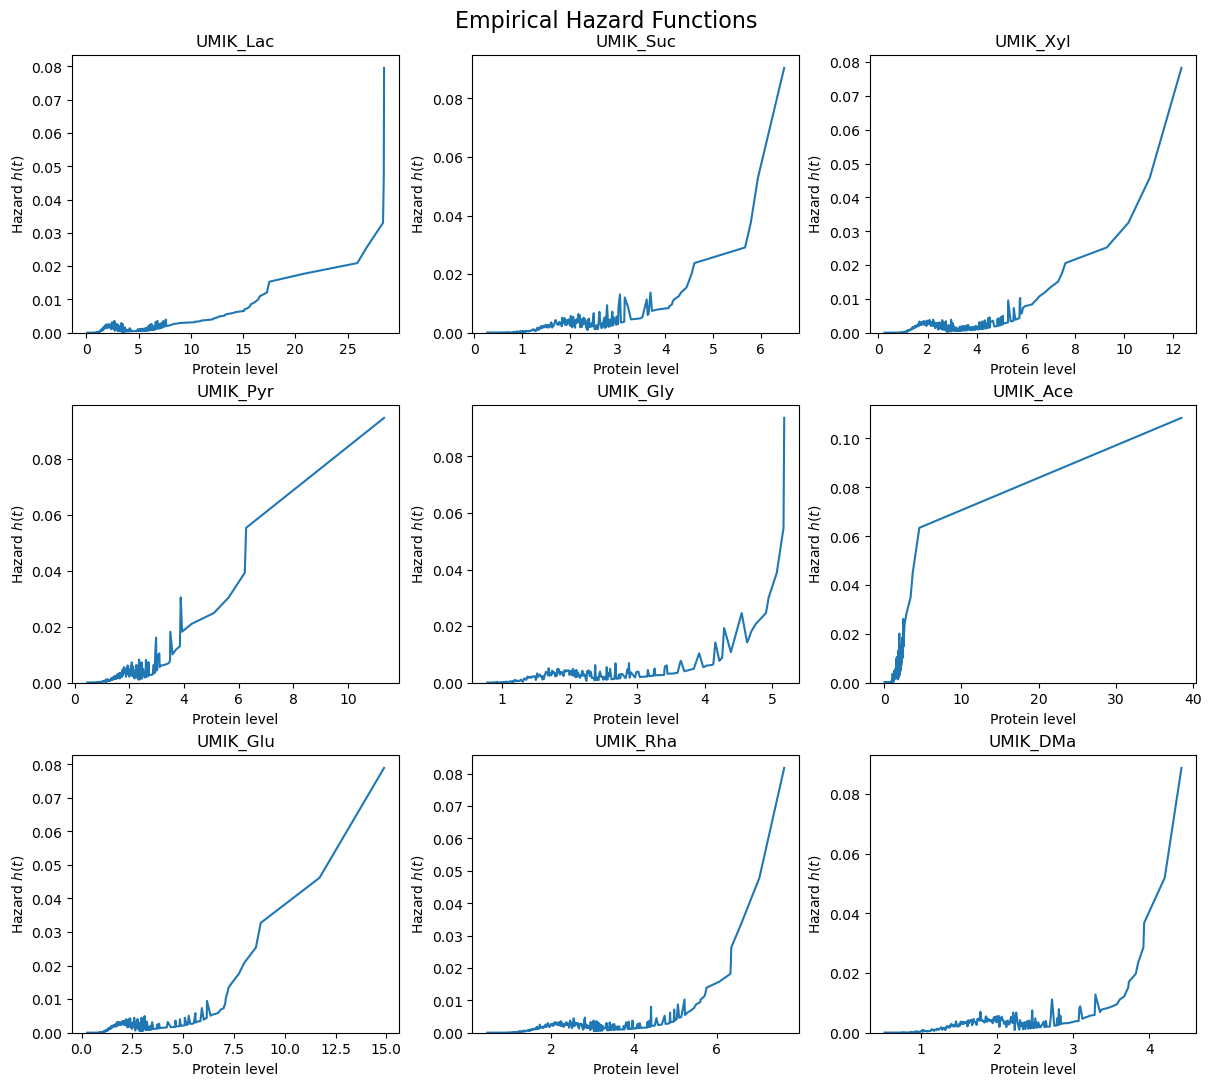

In [55]:
hazards = []                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [56]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

$ S(p) = \frac{1}{1 + e^{a (p - b)}}$

$a$: Steepness

$b$: Inflection point

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_13370/290730065.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(a * (t - b)))


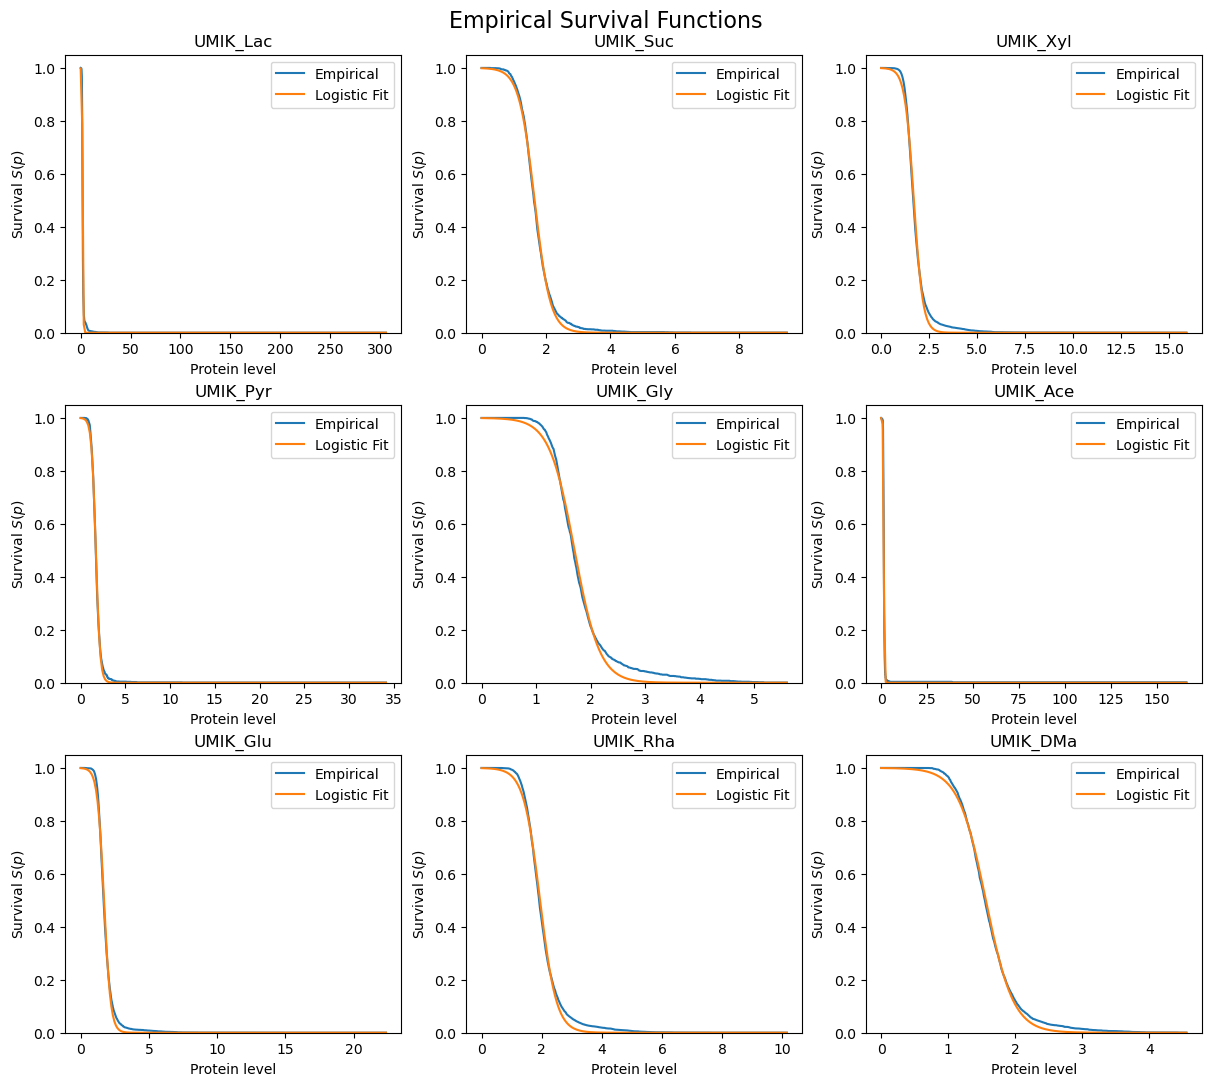

In [57]:
hazards = []                         

for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(logistic_survival, grid, survival, p0=[1, 1])
    grid_fit = np.linspace(min(grid), max(grid), 200)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, logistic_survival(grid_fit, *popt), label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["a", "b"]

In [43]:
fittingParams

,a,b
0,3.089542,1.961065
1,4.128120,1.646843
2,4.218094,1.705076
3,4.202591,1.695683
4,4.325874,1.706997
5,5.722243,1.488529
6,4.091372,1.710214
7,3.653689,1.945537
8,4.858559,1.561460


Text(0.5, 1.0, 'Fitting parameters')

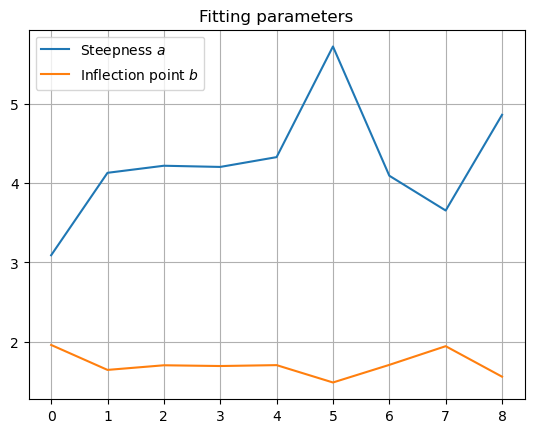

In [58]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]

plt.plot(fittingParams["a"], label ='Steepness $a$')
plt.plot(fittingParams["b"], label ='Inflection point $b$')
plt.legend()
plt.grid()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8])
plt.title("Fitting parameters")

Text(0.5, 1.0, 'Scatter Plot of Fitting Parameters')

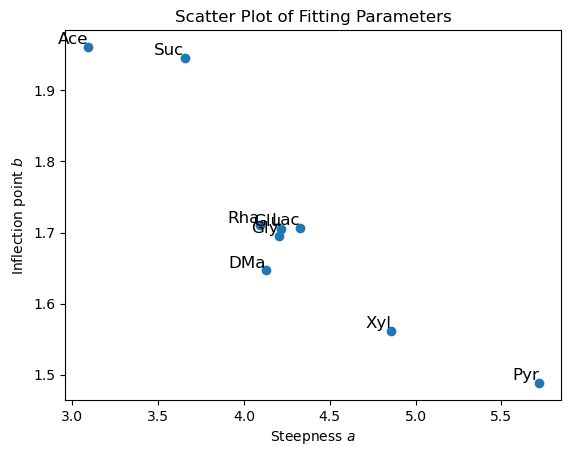

In [59]:
a = fittingParams["a"]
b = fittingParams["b"]

plt.scatter(a,b)
for i, label in enumerate(sugars):
    plt.text(a[i], b[i], label, fontsize=12, ha='right', va='bottom')
plt.xlabel('Steepness $a$')
plt.ylabel('Inflection point $b$')
plt.title('Scatter Plot of Fitting Parameters')

### Superimposing the empirical calculation with the fit